# Time Domain Comparisons

This notebook compares methods that operate in the time domain. 

Compared methods:
- Hurst exponent
- detrended fluctuation analysis
- Hjorth Complexity
- Lempel Ziv Complexity 
- Higuchi Fractal Dimension
- Permutation Entropy
- Approximate Entropy

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from neurodsp.sim import sim_combined
from neurodsp.utils import set_random_seed

from antropy import higuchi_fd
from antropy import perm_entropy, app_entropy

from bootstrap import bootstrap_corr

In [2]:
# Import custom code
import sys; from pathlib import Path
sys.path.append(str(Path('..').resolve()))

from apm.run import run_comparisons
from apm.plts import plot_dots
from apm.utils import format_corr, sampler

from apm.methods import app_entropy, perm_entropy
from apm.methods import hurst, dfa, hjorth_complexity, lempelziv
from apm.methods.settings import HURST_PARAMS, DFA_PARAMS, AP_ENT_PARAMS, PE_ENT_PARAMS

from apm.sim.settings import FS, SIM_PARAMS_COMB

## Settings

In [3]:
# Set the random seed
set_random_seed(111)

In [4]:
# Notebook settings
SAVE_FIG = False

## Collect Methods

In [5]:
# Define ranges to sample parameters from
samplers = {'update_comb_exp' : sampler(np.arange(-2.5, 0, 0.1)),
            'update_pow' : sampler(np.arange(0, 1, 0.1)),
            'update_freq' : sampler(np.arange(5, 35, 1))}

In [6]:
# Define measures to apply
measures = {hurst : HURST_PARAMS, 
            dfa : DFA_PARAMS,
            hjorth_complexity : {}, 
            lempelziv : {},
            higuchi_fd : {},
            app_entropy : AP_ENT_PARAMS,
            perm_entropy : PE_ENT_PARAMS}

## Run Simulations

In [7]:
N_SIMS = 1000

In [8]:
# Run simulations, comparing specparam exponent to entropy
outputs = run_comparisons(sim_combined, SIM_PARAMS_COMB, measures, samplers, n_sims=N_SIMS)

### Fluctuations to Complexity

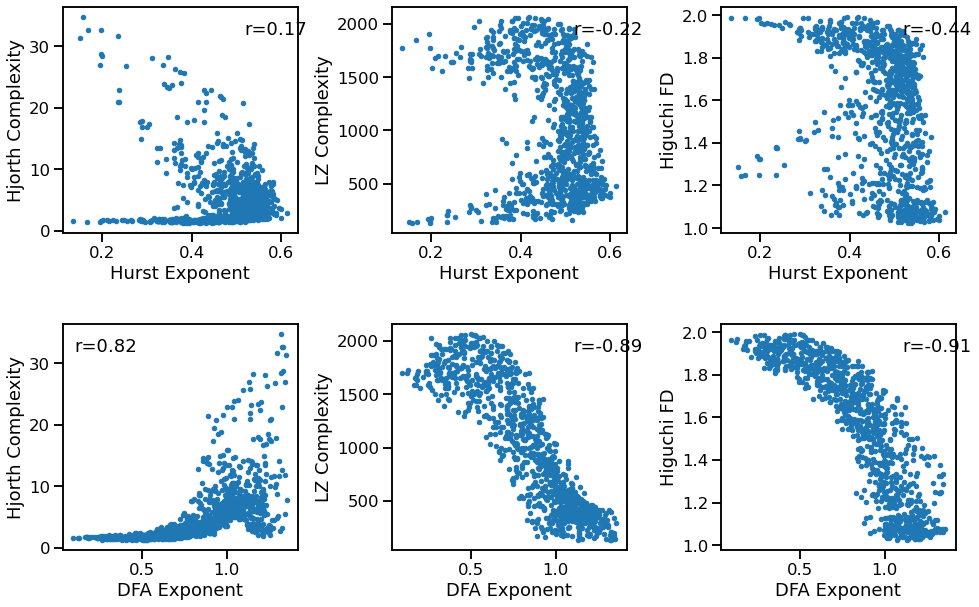

In [9]:
# Plot comparisons
_, axes = plt.subplots(2, 3, figsize=[16, 10])
plot_dots(outputs['hurst'], outputs['hjorth_complexity'], tposition='tr',
          xlabel='Hurst Exponent', ylabel='Hjorth Complexity', ax=axes[0, 0])
plot_dots(outputs['hurst'], outputs['lempelziv'], tposition='tr',
          xlabel='Hurst Exponent', ylabel='LZ Complexity', ax=axes[0, 1])
plot_dots(outputs['hurst'], outputs['higuchi_fd'],
          tposition='tr',
          xlabel='Hurst Exponent', ylabel='Higuchi FD', ax=axes[0, 2])
plot_dots(outputs['dfa'], outputs['hjorth_complexity'], tposition='tl',
          xlabel='DFA Exponent', ylabel='Hjorth Complexity', ax=axes[1, 0])
plot_dots(outputs['dfa'], outputs['lempelziv'], tposition='tr',
          xlabel='DFA Exponent', ylabel='LZ Complexity', ax=axes[1, 1])
plot_dots(outputs['dfa'], outputs['higuchi_fd'], tposition='tr',
          xlabel='DFA Exponent', ylabel='Higuchi FD', ax=axes[1, 2])
plt.subplots_adjust(wspace=0.4, hspace=0.4)

In [10]:
# Compute bootstrapped correlations
corrs_hst_hjo = bootstrap_corr(outputs['hurst'], outputs['hjorth_complexity'])
corrs_hst_lzc = bootstrap_corr(outputs['hurst'], outputs['lempelziv'])
corrs_hst_hfd = bootstrap_corr(outputs['hurst'], outputs['higuchi_fd'])
corrs_dfa_hjo = bootstrap_corr(outputs['dfa'], outputs['hjorth_complexity'])
corrs_dfa_lzc = bootstrap_corr(outputs['dfa'], outputs['lempelziv'])
corrs_dfa_hfd = bootstrap_corr(outputs['dfa'], outputs['higuchi_fd'])

In [11]:
print('Correlations:')
print('  HST & HJO:  ', format_corr(*corrs_hst_hjo))
print('  HST & LZC:  ', format_corr(*corrs_hst_lzc))
print('  HST & HFD:  ', format_corr(*corrs_hst_hfd))
print('  DFA & HJO:  ', format_corr(*corrs_dfa_hjo))
print('  DFA & LZC:  ', format_corr(*corrs_dfa_lzc))
print('  DFA & HFD:  ', format_corr(*corrs_dfa_hfd))

Correlations:
  HST & HJO:   r=+0.173  CI[+0.101, +0.242],  p=0.000
  HST & LZC:   r=-0.222  CI[-0.288, -0.154],  p=0.000
  HST & HFD:   r=-0.441  CI[-0.494, -0.382],  p=0.000
  DFA & HJO:   r=+0.820  CI[+0.795, +0.843],  p=0.000
  DFA & LZC:   r=-0.890  CI[-0.899, -0.879],  p=0.000
  DFA & HFD:   r=-0.907  CI[-0.914, -0.897],  p=0.000


### Complexity to Entropy

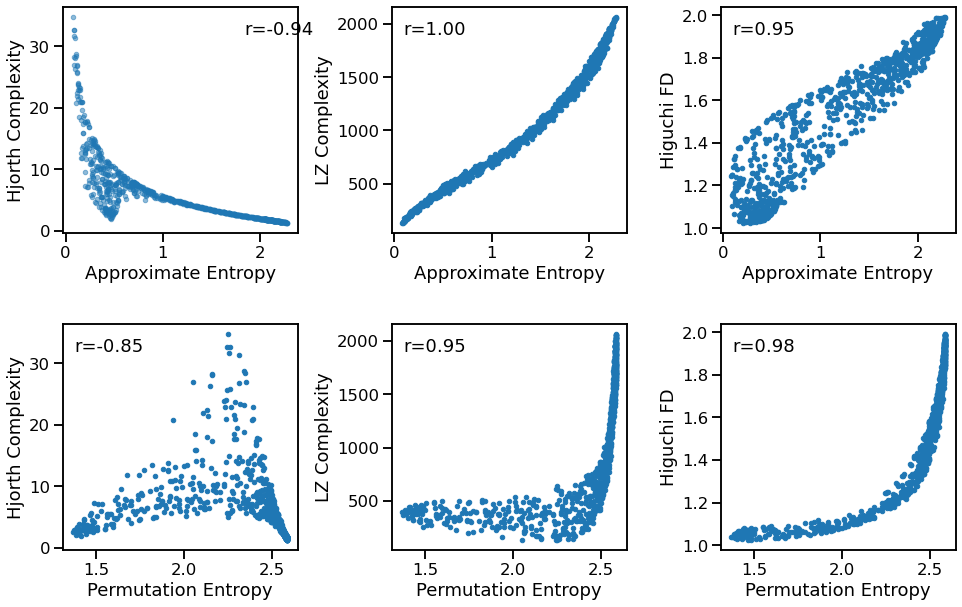

In [18]:
# Plot comparisons
_, axes = plt.subplots(2, 3, figsize=[16, 10])
plot_dots(outputs['app_entropy'], outputs['hjorth_complexity'], tposition='tr',
          xlabel='Approximate Entropy', ylabel='Hjorth Complexity', ax=axes[0, 0])
plot_dots(outputs['app_entropy'], outputs['lempelziv'], tposition='tl',
          xlabel='Approximate Entropy', ylabel='LZ Complexity', ax=axes[0, 1])
plot_dots(outputs['app_entropy'], outputs['higuchi_fd'], tposition='tl',
          xlabel='Approximate Entropy', ylabel='Higuchi FD', ax=axes[0, 2])
plot_dots(outputs['perm_entropy'], outputs['hjorth_complexity'], tposition='tl',
          xlabel='Permutation Entropy', ylabel='Hjorth Complexity', ax=axes[1, 0])
plot_dots(outputs['perm_entropy'], outputs['lempelziv'], tposition='tl',
          xlabel='Permutation Entropy', ylabel='LZ Complexity', ax=axes[1, 1])
plot_dots(outputs['perm_entropy'], outputs['higuchi_fd'], tposition='tl',
          xlabel='Permutation Entropy', ylabel='Higuchi FD', ax=axes[1, 2])
plt.subplots_adjust(wspace=0.4, hspace=0.4)

In [13]:
# Compute bootstrapped correlations
corrs_aen_hjo = bootstrap_corr(outputs['app_entropy'], outputs['hjorth_complexity'])
corrs_aen_lzc = bootstrap_corr(outputs['app_entropy'], outputs['lempelziv'])
corrs_aen_hfd = bootstrap_corr(outputs['app_entropy'], outputs['higuchi_fd'])
corrs_pen_hjo = bootstrap_corr(outputs['perm_entropy'], outputs['hjorth_complexity'])
corrs_pen_lzc = bootstrap_corr(outputs['perm_entropy'], outputs['lempelziv'])
corrs_pen_hfd = bootstrap_corr(outputs['perm_entropy'], outputs['higuchi_fd'])

In [14]:
print('Correlations:')
print('  AEN & HJO:  ', format_corr(*corrs_aen_hjo))
print('  AEN & LZC:  ', format_corr(*corrs_aen_lzc))
print('  AEN & HFD:  ', format_corr(*corrs_aen_hfd))
print('  PEN & HJO:  ', format_corr(*corrs_pen_hjo))
print('  PEN & LZC:  ', format_corr(*corrs_pen_lzc))
print('  PEN & HFD:  ', format_corr(*corrs_pen_hfd))

Correlations:
  AEN & HJO:   r=-0.944  CI[-0.958, -0.928],  p=0.000
  AEN & LZC:   r=+0.998  CI[+0.997, +0.998],  p=0.000
  AEN & HFD:   r=+0.945  CI[+0.936, +0.952],  p=0.000
  PEN & HJO:   r=-0.852  CI[-0.880, -0.821],  p=0.000
  PEN & LZC:   r=+0.947  CI[+0.938, +0.954],  p=0.000
  PEN & HFD:   r=+0.983  CI[+0.979, +0.985],  p=0.000


### Entropy to Fluctuations

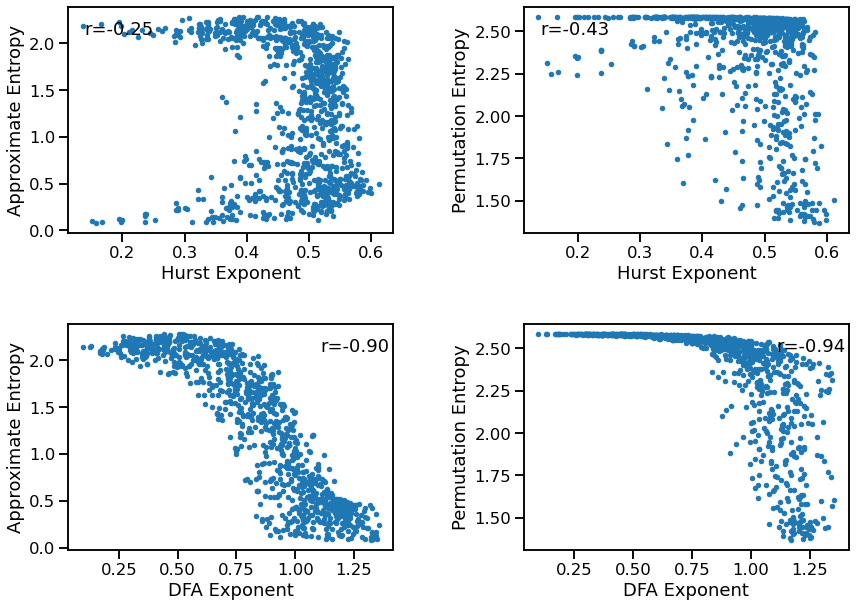

In [15]:
# Plot comparisons
_, axes = plt.subplots(2, 2, figsize=[14, 10])
plot_dots(outputs['hurst'], outputs['app_entropy'], tposition='tl',
          xlabel='Hurst Exponent', ylabel='Approximate Entropy', ax=axes[0, 0])
plot_dots(outputs['hurst'], outputs['perm_entropy'], tposition='tl',
          xlabel='Hurst Exponent', ylabel='Permutation Entropy', ax=axes[0, 1])
plot_dots(outputs['dfa'], outputs['app_entropy'], tposition='tr',
          xlabel='DFA Exponent', ylabel='Approximate Entropy', ax=axes[1, 0])
plot_dots(outputs['dfa'], outputs['perm_entropy'], tposition='tr',
          xlabel='DFA Exponent', ylabel='Permutation Entropy', ax=axes[1, 1])
plt.subplots_adjust(wspace=0.4, hspace=0.4)

In [16]:
# Compute bootstrapped correlations
corrs_hst_aen = bootstrap_corr(outputs['hurst'], outputs['app_entropy'])
corrs_hst_pen = bootstrap_corr(outputs['hurst'], outputs['perm_entropy'])
corrs_dfa_aen = bootstrap_corr(outputs['dfa'], outputs['app_entropy'])
corrs_dfa_pen = bootstrap_corr(outputs['dfa'], outputs['perm_entropy'])

In [17]:
print('Correlations:')
print('  HST & AEN:  ', format_corr(*corrs_hst_aen))
print('  HST & PEN:  ', format_corr(*corrs_hst_pen))
print('  DFA & AEN:  ', format_corr(*corrs_dfa_aen))
print('  DFA & PEN:  ', format_corr(*corrs_dfa_pen))

Correlations:
  HST & AEN:   r=-0.255  CI[-0.319, -0.188],  p=0.000
  HST & PEN:   r=-0.431  CI[-0.486, -0.371],  p=0.000
  DFA & AEN:   r=-0.905  CI[-0.913, -0.893],  p=0.000
  DFA & PEN:   r=-0.941  CI[-0.947, -0.932],  p=0.000


## Conclusions

Comparing between these methods, overall we can see that:
- Fluctuation and complexity measures have varying, and generally non-linear, relationships to each other
- There is generally (though not exclusively) a positive correlation between entropy measures and complexity measures
- Entropy is generally negatively correlated to fluctuation measures, though the pattern is non-linear